In [1]:
import numpy as np
import pandas as pd

df = pd.read_csv("../data/total_data.csv")

In [2]:
df.drop(columns=['Unnamed: 0'], inplace=True)

In [3]:
df.rename(columns={"full_date": "date_time",
                  "pm": "value"}, inplace=True)

In [4]:
from sklearn.model_selection import TimeSeriesSplit, cross_val_score
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler, FunctionTransformer
from sklearn.metrics import mean_squared_error, mean_absolute_error

In [5]:
from functions import holt_winters_imputation_and_expand, plot_imputation_results

In [6]:
import sktime
from matplotlib import pyplot
import matplotlib as plt
import seaborn
import datetime
import pandas as pd
import statsmodels
import numpy as np

In [7]:
df.set_index("date_time", inplace=True)

df.index = pd.to_datetime(df.index)

# Generate the complete range of dates
full_range = pd.date_range(start=df.index.min(), end=df.index.max(), freq='D')

# Reindex the DataFrame to include all dates
df = df.reindex(full_range)

# Set the index name back (optional)
df.index.name = 'date_time'

In [8]:
# df['value'] = holt_winters_imputation_and_expand(
#     df['value'],
#     seasonal_periods=365,
# )
# df.to_csv("../data/imputed_mean.csv")

In [9]:
df = pd.read_csv("../data/imputed_mean.csv")

In [10]:
df.set_index("date_time", inplace=True)

In [ ]:
test_date = "2020-03-01"
test_date = "2020-01-01"
test_date = "2019-06-01"
test_date = "2019-01-01" # 57 - 650
test_date = "2018-06-01" # 38 (31) - 436
# test_date = "2018-04-01" # mnogo
# test_date = "2018-01-01" # mnogo
# test_date = "2017-10-01" # mnogo
df_train = df[df.index < test_date].copy()
df_test = df[df.index >= test_date].copy()

df_train.shape, df_test.shape

((436, 1), (860, 1))

In [96]:
def mape(y_true, y_pred):
    return np.mean(np.abs((y_true - y_pred) / (y_true + 1e-9))) * 100

from sklearn.metrics import mean_squared_error

def evaluate_on_test(y_hat, y_true):
    return mape(y_true, y_hat), np.sqrt(mean_squared_error(y_hat, y_true))

def plot_preds(y_hat, y_true):
    predictions = pd.DataFrame({
        "Preds": y_hat,
        "Actual": y_true,
        # "train": t['value']
    })
    _, ax = pyplot.subplots()
    ax = predictions.plot(ax=ax)

## data prep

In [97]:
from statsforecast.models import SeasonalNaive
from statsforecast.core import StatsForecast
import pandas as pd

# Prepare your data
data = pd.DataFrame({'ds': df_train.index,
                     'y': df_train['value'].values})
data['unique_id'] = "mean"

data['ds'] = pd.to_datetime(data['ds'])

In [98]:
# Prepare your data
data_test = pd.DataFrame({'ds': df_test.index,
                     'y': df_test['value'].values})
data_test['unique_id'] = "mean"

data_test['ds'] = pd.to_datetime(data_test['ds'])

## ML models basics

In [99]:
def train_test_split(series, test_size=0.2):
    """
    Splits the series into train and test sets.

    Parameters:
        series (array-like): The transformed series to split.
        test_size (float): Proportion of the series to include in the test set (default: 0.2).
    
    Returns:
        tuple: (train_series, test_series)
    """
    try:
        n = len(series)
        test_count = int(n * test_size)
        train_series = series[:-test_count]
        test_series = series[-test_count:]
        return train_series, test_series
    except Exception as e:
        warnings.warn(f"Failed to split series into train and test sets: {e}")
        return series, None


In [100]:
# from statsmodels.tsa.seasonal import seasonal_decompose

# data = preprocessor.remove_seasonality(data)
# data = data[~np.isnan(data)]
# result = seasonal_decompose(data, model='additive', period=300)
# result.plot()
# pyplot.show()

In [101]:
from mlforecast import MLForecast
from mlforecast.target_transforms import Differences
from sklearn.linear_model import LinearRegression


In [102]:
# fcst = MLForecast(
#     models=LinearRegression(),
#     freq='D',  # our serie has a monthly frequency
#     lags=[7, 14, 30, 90, 180, 365],
#     target_transforms=[Differences([1])],
# )
# fcst.fit(data)

In [103]:
# preds = fcst.predict(len(df_test['value']))
# mape(preds['LinearRegression'].values, df_test['value'].values), \
# # plot_preds(preds['LinearRegression'].values, df_test['value'].values)

In [104]:
# fcst = MLForecast(
#     models=[],
#     freq='D',  # our serie has a monthly frequency
#     lags=[1, 3, 7, 14, 30, 45, 60, 80, 90, 120, 150, 180, 365],
#     target_transforms=[Differences([365])],
# )
# prep = fcst.preprocess(data)
# # prep

In [105]:
# prep.drop(columns=['unique_id', 'ds']).corr()['y']

In [106]:
# # Re-import necessary libraries after execution state reset
# from pandas.tseries.holiday import AbstractHolidayCalendar, Holiday
# from pandas.tseries.offsets import Day
# import pandas as pd

# # Define Kazakhstan Holidays Calendar
# class KazakhstanHolidaysCalendar(AbstractHolidayCalendar):
#     rules = [
#         # Holiday("Pre New Year 1", month=12, day=30),
#         # Holiday("Pre New Year 2", month=12, day=31),
#         # Holiday("New Year", month=1, day=1),
#         # Holiday("New Year Holiday", month=1, day=2),
#         # Holiday("Students", month=1, day=15),
#         # Holiday("Women’s Day", month=3, day=8),
#         # Holiday("Nauryz Day 1", month=3, day=21),
#         # Holiday("Nauryz Day 2", month=3, day=22),
#         # Holiday("Nauryz Day 3", month=3, day=23),
#         # Holiday("Unity Day", month=5, day=1),
#         # Holiday("Victory Day", month=5, day=9),
#         # Holiday("Capital City Day", month=7, day=6),
#         # Holiday("Constitution Day", month=8, day=30),
#         # Holiday("Independence Day", month=12, day=16),
#         # Holiday("Independence Day Holiday", month=12, day=17)
#     ]

# # Generate holiday dates for Kazakhstan (2017-2020)
# calendar = KazakhstanHolidaysCalendar()
# holidays = calendar.holidays(start="2017-01-01", end="2022-12-31")

# # Convert to DataFrame
# kazakhstan_holidays = pd.DataFrame({
#     'holiday': [holiday.strftime('%B %d, %Y') for holiday in holidays],
#     'ds': holidays,
#     'lower_window': 0,
#     'upper_window': 1
# })

# # Function to estimate Kurban Ait (Eid al-Adha) dates (approximate based on Islamic calendar shifts)
# # kurban_ait_dates = pd.to_datetime(["2017-09-01", "2018-08-21", "2019-08-11", "2020-07-31"])
# # kurban_ait_df = pd.DataFrame({
# #     'holiday': 'Kurban Ait',
# #     'ds': kurban_ait_dates,
# #     'lower_window': 0,
# #     'upper_window': 1
# # })

# # # Append Kurban Ait to holidays DataFrame
# kazakhstan_holidays = pd.concat([kazakhstan_holidays, kurban_ait_df], ignore_index=True)

16:42:45 - cmdstanpy - INFO - Chain [1] start processing
16:42:45 - cmdstanpy - INFO - Chain [1] done processing


Prophet RMSE: 26.882404720169
Prophet MAPE: 38.4313181046919%


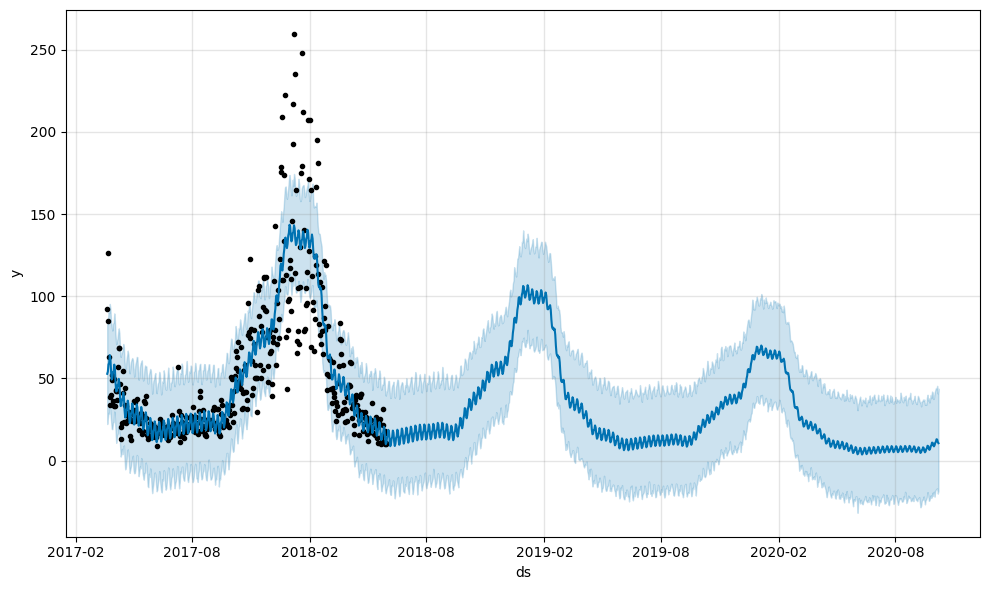

In [107]:
# Install Prophet if not already installed
# !pip install prophet

from prophet import Prophet
import pandas as pd
import matplotlib.pyplot as plt

# Load and prepare data for Prophet
df_prophet = df_train.reset_index()
df_prophet.rename(columns={'date_time': 'ds', 'value': 'y'}, inplace=True)

# Define the Prophet model
model = Prophet(seasonality_mode='multiplicative', yearly_seasonality=True, weekly_seasonality=True, 
                # holidays=kazakhstan_holidays
                )
# Add custom seasonalities
# model.add_seasonality(name='monthly', period=30.5, fourier_order=8)

# Train model again
model.fit(df_prophet)

# Create future dataframe (next 6 months)
future = model.make_future_dataframe(periods=len(df_test['value']), freq='D')

# Make predictions
forecast = model.predict(future)

# Plot the forecast
fig = model.plot(forecast)
# plt.title("Facebook Prophet Forecast")
# plt.show()

# Evaluate Performance (on test data)
test_data_prophet = data_test.copy() # Last 6 months
forecast_values = forecast[['ds', 'yhat']].set_index('ds').loc[test_data_prophet['ds']]

# Compute RMSE and MAPE
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error
import numpy as np

rmse_prophet = np.sqrt(mean_squared_error(test_data_prophet['y'], forecast_values['yhat']))
mape_prophet = mean_absolute_percentage_error(test_data_prophet['y'], forecast_values['yhat']) * 100

print(f"Prophet RMSE: {rmse_prophet}")
print(f"Prophet MAPE: {mape_prophet}%")


In [108]:
abc

NameError: name 'abc' is not defined

In [109]:
from itertools import product

# Define parameter grid
param_grid = {
    'changepoint_prior_scale': np.arange(0.01, 0.25, 0.05),
    'seasonality_prior_scale': np.arange(0.5, 5, 0.5)
}

# Run a grid search
best_mape = float('inf')
best_params = None

for params in product(param_grid['changepoint_prior_scale'], param_grid['seasonality_prior_scale']):
    model = Prophet(changepoint_prior_scale=params[0], seasonality_prior_scale=params[1], yearly_seasonality=True, weekly_seasonality=True, seasonality_mode='multiplicative')
    model.fit(df_prophet)
    forecast = model.predict(future)
    
    # Evaluate
    forecast_values = forecast[['ds', 'yhat']].set_index('ds').loc[test_data_prophet['ds']]
    mape = mean_absolute_percentage_error(test_data_prophet['y'], forecast_values['yhat']) * 100
    
    if mape < best_mape:
        best_mape = mape
        best_params = params

print(f"Best Params: {best_params}, Best MAPE: {best_mape}%")


16:43:04 - cmdstanpy - INFO - Chain [1] start processing
16:43:05 - cmdstanpy - INFO - Chain [1] done processing
16:43:05 - cmdstanpy - INFO - Chain [1] start processing
16:43:05 - cmdstanpy - INFO - Chain [1] done processing
16:43:06 - cmdstanpy - INFO - Chain [1] start processing
16:43:06 - cmdstanpy - INFO - Chain [1] done processing
16:43:06 - cmdstanpy - INFO - Chain [1] start processing
16:43:06 - cmdstanpy - INFO - Chain [1] done processing
16:43:07 - cmdstanpy - INFO - Chain [1] start processing
16:43:07 - cmdstanpy - INFO - Chain [1] done processing
16:43:07 - cmdstanpy - INFO - Chain [1] start processing
16:43:07 - cmdstanpy - INFO - Chain [1] done processing
16:43:07 - cmdstanpy - INFO - Chain [1] start processing
16:43:08 - cmdstanpy - INFO - Chain [1] done processing
16:43:08 - cmdstanpy - INFO - Chain [1] start processing
16:43:08 - cmdstanpy - INFO - Chain [1] done processing
16:43:08 - cmdstanpy - INFO - Chain [1] start processing
16:43:09 - cmdstanpy - INFO - Chain [1]

Best Params: (0.01, 2.5), Best MAPE: 31.256364548384514%


In [ ]:
from TimeSeriesImputer import TimeSeriesPreprocessor

In [ ]:
data = df['value'].values.copy()
preprocessor = TimeSeriesPreprocessor(seasonal_period=365)

steps = ['log', 'trend', 'seasonality', 'boxcox', 'standardize']
transformed_series = preprocessor.create_pipeline(data, steps)

c:\Users\77019\Desktop\code\raka\airkaz\code\TimeSeriesImputer.py:68: UserWarning: Failed to apply Box-Cox transformation: The `x` argument of `boxcox_normmax` must contain only positive, finite, real numbers.
  warnings.warn(f"Failed to apply Box-Cox transformation: {e}")


In [ ]:
int(len(df['value']) * 0.5)

648

In [ ]:
df['value'][:int(len(df['value']) * 0.62)]

date_time
2017-03-22     91.982979
2017-03-23     84.649269
2017-03-24    126.039535
2017-03-25     63.183913
2017-03-26     38.572597
                 ...    
2019-05-29     12.436668
2019-05-30     10.951993
2019-05-31     10.103609
2019-06-01     12.608448
2019-06-02     17.126061
Name: value, Length: 803, dtype: float64

In [ ]:
distr_model_dict = {}
test_size = 0.37
orig_train, orig_test = train_test_split(transformed_series["original"], test_size)
start_date = df.index[0]

for name, series in transformed_series.items():
    train_series, test_series = train_test_split(transformed_series[name], test_size)

    if len(train_series) == len(orig_train):
        df_prophet_train = pd.DataFrame({'ds': df.index[:len(train_series)], 'y': train_series})
        df_prophet_test = pd.DataFrame({'ds': df.index[len(train_series):], 'y': test_series})
        model = Prophet(seasonality_mode='multiplicative', yearly_seasonality=True, weekly_seasonality=True)
    else:
        df_prophet_train = pd.DataFrame({'ds': pd.date_range(start=start_date, periods=len(train_series), freq='D'), 
                                         'y': train_series})
        df_prophet_test = pd.DataFrame({'ds': pd.date_range(start=df_prophet_train['ds'].iloc[-1] + pd.Timedelta(days=1), 
                                                            periods=len(test_series), freq='D'), 
                                        'y': test_series})
        model = Prophet(seasonality_mode='multiplicative', holidays_mode=False)
    # TODO попробовать разные параметры, авто сезонность, мод аддитив

    model.fit(df_prophet_train)

    future = model.make_future_dataframe(periods=len(test_series), freq='D')
    forecast = model.predict(future)

    # Evaluate Performance (on test data)
    test_data_prophet = df_prophet_test.copy() # Last 6 months
    forecast_values = forecast[['ds', 'yhat']].set_index('ds').loc[test_data_prophet['ds']]

    rmse_prophet = np.sqrt(mean_squared_error(test_data_prophet['y'], forecast_values['yhat']))
    mape_prophet = mean_absolute_percentage_error(test_data_prophet['y'], forecast_values['yhat']) * 100

    print(f"{name} Metrics:", rmse_prophet, mape_prophet)

    if mape_prophet < 29:
        distr_model_dict[name] = [train_series, test_series, forecast_values['yhat']]

21:07:48 - cmdstanpy - INFO - Chain [1] start processing
21:07:49 - cmdstanpy - INFO - Chain [1] done processing


original Metrics: 16.22088529768072 29.428380974154468


21:07:49 - cmdstanpy - INFO - Chain [1] start processing
21:07:50 - cmdstanpy - INFO - Chain [1] done processing


log Metrics: 0.3515360062703499 8.617569659291634


21:07:51 - cmdstanpy - INFO - Chain [1] start processing
21:07:51 - cmdstanpy - INFO - Chain [1] done processing


trend Metrics: 17.58220004006141 100.53644636952919


21:07:53 - cmdstanpy - INFO - Chain [1] start processing
21:07:53 - cmdstanpy - INFO - Chain [1] done processing


seasonality Metrics: 17.964460514478333 87.88028789638048


21:07:54 - cmdstanpy - INFO - Chain [1] start processing
21:07:54 - cmdstanpy - INFO - Chain [1] done processing


boxcox Metrics: 0.08710997345889922 3.6898237791956


21:07:55 - cmdstanpy - INFO - Chain [1] start processing
21:07:55 - cmdstanpy - INFO - Chain [1] done processing


standardize Metrics: 0.6469519506363787 299.15146124692745


21:07:58 - cmdstanpy - INFO - Chain [1] start processing
21:07:58 - cmdstanpy - INFO - Chain [1] done processing


log_trend Metrics: 0.39514366907087156 102.05040083703281


21:08:02 - cmdstanpy - INFO - Chain [1] start processing
21:08:03 - cmdstanpy - INFO - Chain [1] done processing


log_seasonality Metrics: 0.3538617725115335 8.256296318648387


21:08:04 - cmdstanpy - INFO - Chain [1] start processing
21:08:04 - cmdstanpy - INFO - Chain [1] done processing


log_boxcox Metrics: 0.03139335627580553 2.6856842144919257


21:08:07 - cmdstanpy - INFO - Chain [1] start processing
21:08:07 - cmdstanpy - INFO - Chain [1] done processing


log_standardize Metrics: 0.9448908791905225 204.23402809511185


21:08:10 - cmdstanpy - INFO - Chain [1] start processing
21:08:10 - cmdstanpy - INFO - Chain [1] done processing


trend_seasonality Metrics: 16.79902211240005 106.52233050157996


21:08:12 - cmdstanpy - INFO - Chain [1] start processing
21:08:13 - cmdstanpy - INFO - Chain [1] done processing


trend_boxcox Metrics: 17.58220004006141 100.53644636952919


21:08:14 - cmdstanpy - INFO - Chain [1] start processing
21:08:14 - cmdstanpy - INFO - Chain [1] done processing


trend_standardize Metrics: 0.846514803581536 106.73569445170679


21:08:16 - cmdstanpy - INFO - Chain [1] start processing
21:08:17 - cmdstanpy - INFO - Chain [1] done processing


seasonality_boxcox Metrics: 17.964460514478333 87.88028789638048


21:08:19 - cmdstanpy - INFO - Chain [1] start processing
21:08:19 - cmdstanpy - INFO - Chain [1] done processing


seasonality_standardize Metrics: 0.8490375943035067 259.70489181365514


21:08:22 - cmdstanpy - INFO - Chain [1] start processing
21:08:23 - cmdstanpy - INFO - Chain [1] done processing


boxcox_standardize Metrics: 0.9742244302615141 394.32624196926463


21:08:26 - cmdstanpy - INFO - Chain [1] start processing
21:08:27 - cmdstanpy - INFO - Chain [1] done processing


log_trend_seasonality Metrics: 0.3761081320453273 114.50873897531812


21:08:29 - cmdstanpy - INFO - Chain [1] start processing
21:08:30 - cmdstanpy - INFO - Chain [1] done processing


log_trend_boxcox Metrics: 0.39514366907087156 102.05040083703281


21:08:32 - cmdstanpy - INFO - Chain [1] start processing
21:08:32 - cmdstanpy - INFO - Chain [1] done processing


log_trend_standardize Metrics: 1.1028390738763552 100.93930426505074


21:08:34 - cmdstanpy - INFO - Chain [1] start processing
21:08:34 - cmdstanpy - INFO - Chain [1] done processing


log_seasonality_boxcox Metrics: 0.4521277822012808 9.110780821925307


21:08:36 - cmdstanpy - INFO - Chain [1] start processing
21:08:36 - cmdstanpy - INFO - Chain [1] done processing


log_seasonality_standardize Metrics: 1.1624044935433693 302.36975546367336


21:08:38 - cmdstanpy - INFO - Chain [1] start processing
21:08:38 - cmdstanpy - INFO - Chain [1] done processing


log_boxcox_standardize Metrics: 0.9661377478231548 390.6793265839156


21:08:39 - cmdstanpy - INFO - Chain [1] start processing
21:08:40 - cmdstanpy - INFO - Chain [1] done processing


trend_seasonality_boxcox Metrics: 16.79902211240005 106.52233050157996


21:08:40 - cmdstanpy - INFO - Chain [1] start processing
21:08:40 - cmdstanpy - INFO - Chain [1] done processing


trend_seasonality_standardize Metrics: 0.9280851321915102 100.50803237584873


21:08:41 - cmdstanpy - INFO - Chain [1] start processing
21:08:42 - cmdstanpy - INFO - Chain [1] done processing


trend_boxcox_standardize Metrics: 0.846514803581536 106.73569445170679


21:08:43 - cmdstanpy - INFO - Chain [1] start processing
21:08:43 - cmdstanpy - INFO - Chain [1] done processing


seasonality_boxcox_standardize Metrics: 0.8490375943035067 259.70489181365514


21:08:44 - cmdstanpy - INFO - Chain [1] start processing
21:08:45 - cmdstanpy - INFO - Chain [1] done processing


log_trend_seasonality_boxcox Metrics: 0.3761081320453273 114.50873897531812


21:08:45 - cmdstanpy - INFO - Chain [1] start processing
21:08:46 - cmdstanpy - INFO - Chain [1] done processing
21:08:46 - cmdstanpy - INFO - Chain [1] start processing


log_trend_seasonality_standardize Metrics: 1.1229497969468416 110.42420517187725


21:08:46 - cmdstanpy - INFO - Chain [1] done processing


log_trend_boxcox_standardize Metrics: 1.1028390738763552 100.93930426505074


21:08:47 - cmdstanpy - INFO - Chain [1] start processing
21:08:48 - cmdstanpy - INFO - Chain [1] done processing


log_seasonality_boxcox_standardize Metrics: 1.0980936305795126 237.4065507591743


21:08:49 - cmdstanpy - INFO - Chain [1] start processing
21:08:49 - cmdstanpy - INFO - Chain [1] done processing
21:08:49 - cmdstanpy - INFO - Chain [1] start processing


trend_seasonality_boxcox_standardize Metrics: 0.9280851321915102 100.50803237584873


21:08:49 - cmdstanpy - INFO - Chain [1] done processing


log_trend_seasonality_boxcox_standardize Metrics: 1.1229497969468416 110.42420517187725


log
31.5905403741938
boxcox
26.672536093089317
log_seasonality
89.67515490827094
log_boxcox
25.882299117813584
log_seasonality_boxcox
90.1861417588939


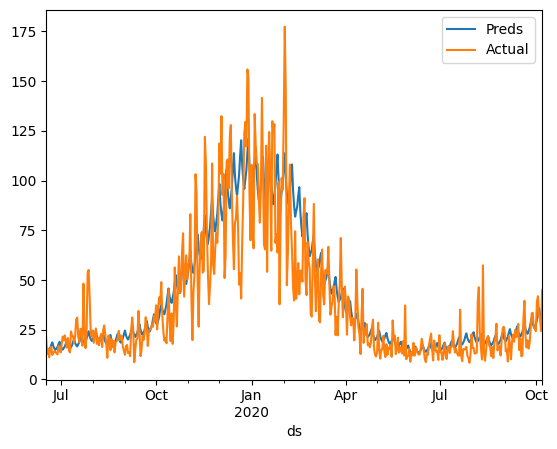

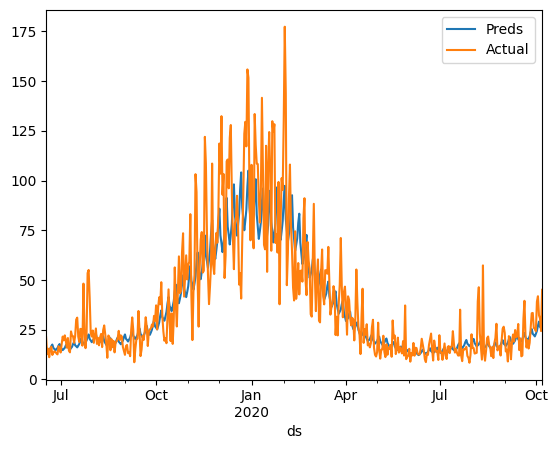

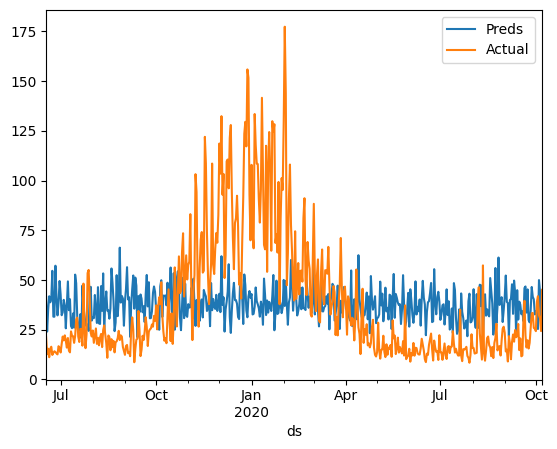

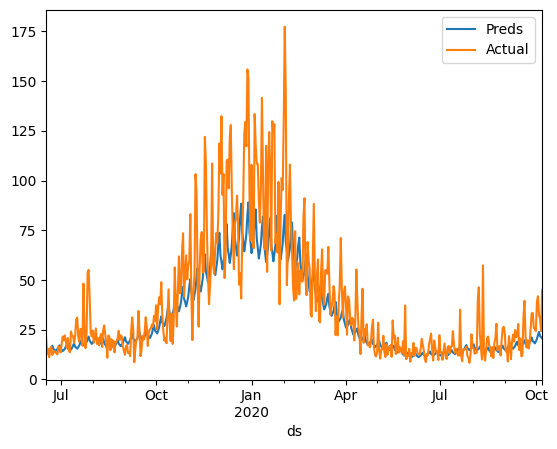

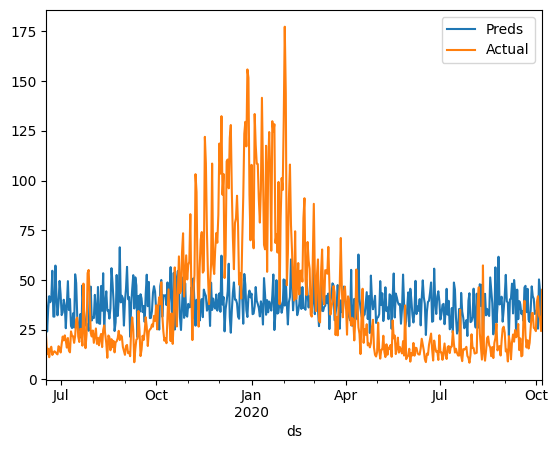

In [ ]:
from copy import deepcopy

for distr_name, res in distr_model_dict.items():
    distr_preprocessor = deepcopy(preprocessor)
    distr_preprocessor.transforms = distr_name.split('_')

    if "boxcox" in distr_name:
        distr_preprocessor.lambda_param = preprocessor.lambdas[distr_name]

    print(distr_name)

    orig_preds = distr_preprocessor.inverse_transform_predictions(res[-1])

    if len(set(orig_preds)) > 1: 
        print(mean_absolute_percentage_error(orig_test, orig_preds) * 100) 
        plot_preds(orig_preds, orig_test)

## lstm

Epoch 1/50


c:\Users\77019\pyver\py312\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


34/34 ━━━━━━━━━━━━━━━━━━━━ 6s 43ms/step - loss: 0.0403
Epoch 2/50
34/34 ━━━━━━━━━━━━━━━━━━━━ 2s 58ms/step - loss: 0.0150
Epoch 3/50
34/34 ━━━━━━━━━━━━━━━━━━━━ 1s 27ms/step - loss: 0.0099
Epoch 4/50
34/34 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - loss: 0.0113
Epoch 5/50
34/34 ━━━━━━━━━━━━━━━━━━━━ 2s 47ms/step - loss: 0.0103
Epoch 6/50
34/34 ━━━━━━━━━━━━━━━━━━━━ 1s 35ms/step - loss: 0.0119
Epoch 7/50
34/34 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step - loss: 0.0108
Epoch 8/50
34/34 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step - loss: 0.0092
Epoch 9/50
34/34 ━━━━━━━━━━━━━━━━━━━━ 2s 59ms/step - loss: 0.0091
Epoch 10/50
34/34 ━━━━━━━━━━━━━━━━━━━━ 1s 39ms/step - loss: 0.0091
Epoch 11/50
34/34 ━━━━━━━━━━━━━━━━━━━━ 3s 76ms/step - loss: 0.0104
Epoch 12/50
34/34 ━━━━━━━━━━━━━━━━━━━━ 1s 42ms/step - loss: 0.0092
Epoch 13/50
34/34 ━━━━━━━━━━━━━━━━━━━━ 2s 52ms/step - loss: 0.0126
Epoch 14/50
34/34 ━━━━━━━━━━━━━━━━━━━━ 3s 95ms/step - loss: 0.0093
Epoch 15/50
34/34 ━━━━━━━━━━━━━━━━━━━━ 2s 62ms/step - loss: 0.0106
Epoch 16/50
34/

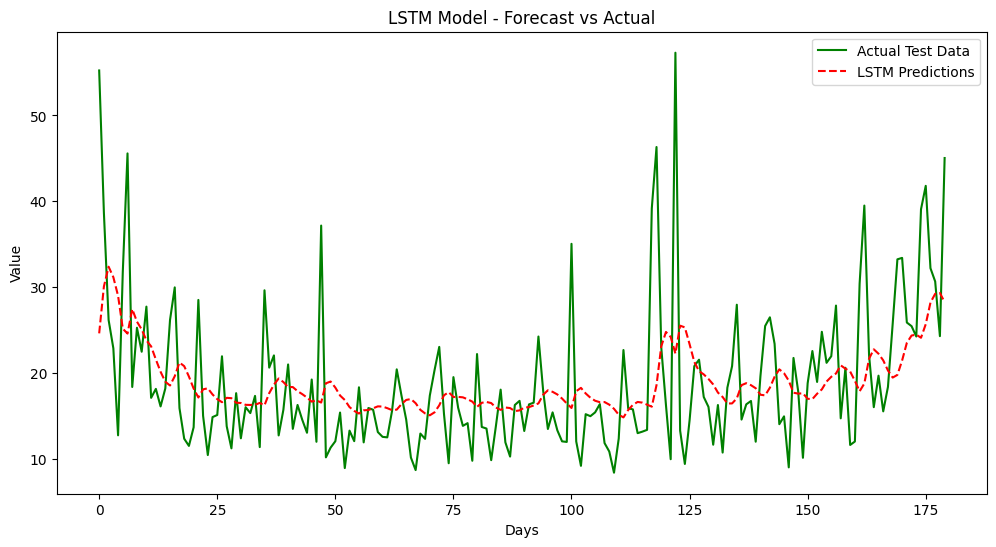

LSTM RMSE: 7.954923084541296
LSTM MAPE: 32.069993481873254%


In [ ]:
# Install TensorFlow if not installed
# !pip install tensorflow numpy pandas scikit-learn matplotlib

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from tensorflow.keras.optimizers import Adam

# Load and normalize data
scaler = MinMaxScaler(feature_range=(0, 1))
df_scaled = scaler.fit_transform(df)

# Prepare training data
def create_sequences(data, seq_length):
    X, y = [], []
    for i in range(len(data) - seq_length):
        X.append(data[i:i+seq_length])
        y.append(data[i+seq_length])
    return np.array(X), np.array(y)

seq_length = 30  # Using 30 days history for each prediction
X, y = create_sequences(df_scaled, seq_length)

# Train-test split
X_train, X_test = X[:-180], X[-180:]
y_train, y_test = y[:-180], y[-180:]

# Reshape input for LSTM
X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], 1))
X_test = X_test.reshape((X_test.shape[0], X_test.shape[1], 1))

# Build LSTM model
# Build an improved LSTM model
model = Sequential([
    LSTM(100, activation='relu', return_sequences=True, input_shape=(seq_length, 1)),  # Increase neurons
    LSTM(50, activation='relu', return_sequences=True),
    LSTM(50, activation='relu'),
    Dense(1)
])

optimizer = Adam(learning_rate=0.001)  # Try 0.001, 0.0005, 0.0001
model.compile(optimizer=optimizer, loss='mse')
# model.compile(optimizer='adam', loss='mse')

# Train model
model.fit(X_train, y_train, epochs=50, batch_size=32, verbose=1)


# Make predictions
y_pred = model.predict(X_test)

# Inverse scale the predictions
y_test_actual = scaler.inverse_transform(y_test.reshape(-1, 1))
y_pred_actual = scaler.inverse_transform(y_pred)

# Plot actual vs predicted values
plt.figure(figsize=(12, 6))
plt.plot(y_test_actual, label="Actual Test Data", color="green")
plt.plot(y_pred_actual, label="LSTM Predictions", color="red", linestyle="dashed")
plt.xlabel("Days")
plt.ylabel("Value")
plt.title("LSTM Model - Forecast vs Actual")
plt.legend()
plt.show()

# Compute RMSE and MAPE
rmse_lstm = np.sqrt(mean_squared_error(y_test_actual, y_pred_actual))
mape_lstm = mean_absolute_percentage_error(y_test_actual, y_pred_actual) * 100

print(f"LSTM RMSE: {rmse_lstm}")
print(f"LSTM MAPE: {mape_lstm}%")
